### Grading
The final score that you will receive for your programming assignment is generated in relation to the total points set in your programming assignment item—not the total point value in the nbgrader notebook.<br>
When calculating the final score shown to learners, the programming assignment takes the percentage of earned points vs. the total points provided by nbgrader and returns a score matching the equivalent percentage of the point value for the programming assignment.<br>
**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES** The autograder will not work properly if your change the variable or method signatures. 

# Ensemble methods (adaBoost, random forests) 

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt 
%matplotlib inline 

In [2]:
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Run the helper code below to create a training and validation set of threes and eights from the MNIST dataset. There is also a helper function to display digits. 

In [3]:
class ThreesandEights:
    """
    Class to store MNIST 3s and 8s data
    """

    def __init__(self, location):

        import pickle, gzip

        # Load the dataset
        f = gzip.open(location, 'rb')

        # Split the data set 
        x_train, y_train, x_test, y_test = pickle.load(f)
                
        # Extract only 3's and 8's for training set 
        self.x_train = x_train[np.logical_or(y_train== 3, y_train == 8), :]
        self.y_train = y_train[np.logical_or(y_train== 3, y_train == 8)]
        self.y_train = np.array([1 if y == 8 else -1 for y in self.y_train])
        
        # Shuffle the training data 
        shuff = np.arange(self.x_train.shape[0])
        np.random.shuffle(shuff)
        self.x_train = self.x_train[shuff,:]
        self.y_train = self.y_train[shuff]

        # Extract only 3's and 8's for validation set 
        self.x_test = x_test[np.logical_or(y_test== 3, y_test == 8), :]
        self.y_test = y_test[np.logical_or(y_test== 3, y_test == 8)]
        self.y_test = np.array([1 if y == 8 else -1 for y in self.y_test])
        
        f.close()

def view_digit(ex, label=None, feature=None):
    """
    function to plot digit examples 
    """
    if label: print("true label: {:d}".format(label))
    img = ex.reshape(21,21)
    col = np.dstack((img, img, img))
    if feature is not None: col[feature[0]//21, feature[0]%21, :] = [1, 0, 0]
    plt.imshow(col)
    plt.xticks([]), plt.yticks([])
    
data = ThreesandEights("data/mnist21x21_3789.pklz")

In [4]:
num_training_examples = len(data.x_train)
num_training_features = len(data.y_train)
num_test_examples = len(data.x_test)
pixels_per_image = len(data.x_train[0])
print("Number of x_train: ", num_training_examples)
print("Number of y_train: ", num_training_features)
print("Number of x_test: ",num_test_examples)
print("number of pixels per image: ", pixels_per_image)
print(data.y_train.shape)

Number of x_train:  2000
Number of y_train:  2000
Number of x_test:  500
number of pixels per image:  441
(2000,)


true label: -1


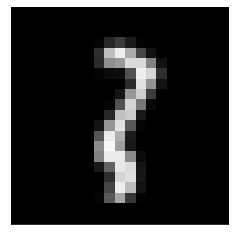

In [5]:
training_index = 1

view_digit(data.x_train[training_index], data.y_train[training_index])

### Problem 1: Building an Adaboost Classifier to classify MNIST digits 3 and 8.

Recall that the model we attempt to learn in AdaBoost is given by 

$$
H({\bf x}) = \textrm{sign}\left[\displaystyle\sum_{k=1}^K\alpha_k h_k({\bf x}) \right]
$$

where $h_k({\bf x})$ is the $k^\textrm{th}$ weak learner and $\alpha_k$ is it's associated ensemble coefficient. 

In [6]:
class AdaBoost:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=3), random_state=1234):
        """
        Create a new adaboost classifier.
        
        Args:
            N (int, optional): Number of weak learners in classifier.
            base (BaseEstimator, optional): Your general weak learner 
            random_state (int, optional): set random generator.  needed for unit testing. 

        Attributes:
            base (estimator): Your general weak learner 
            n_learners (int): Number of weak learners in classifier.
            alpha (ndarray): Coefficients on weak learners. 
            learners (list): List of weak learner instances. 
        """
        
        np.random.seed(random_state)
        
        self.n_learners = n_learners 
        self.base = base
        self.alpha = np.zeros(self.n_learners)
        self.learners = []
        
    def fit(self, X_train, y_train):
        """
        Train AdaBoost classifier on data. Sets alphas and learners. 
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """

        # =================================================================
        # TODO 

        # Note: You can create and train a new instantiation 
        # of your sklearn decision tree as follows 
        # you don't have to use sklearn's fit function, 
        # but it is probably the easiest way 

#         w = np.ones(len(y_train))
#         h = clone(self.base)
#         h.fit(X_train, y_train, sample_weight=w)
        
        # =================================================================
        
        weights = np.ones(len(y_train)) / len(y_train)

        for _ in range(self.n_learners):
            dtc = clone(self.base)
            dtc = dtc.fit(X_train, y_train, sample_weight=weights)
            y_pred = dtc.predict(X_train)
            error_returns = self.error_rate(y_train, y_pred, weights)
            error = error_returns[0]
            y_i = error_returns[1]
            alpha = 0.5 * (np.log((1-error)/error))
            self.learners.append(dtc)
            self.alpha[_] = alpha                    # updates alpha list
            
    
            for i in range(len(weights)):                   #update weights
                if y_i[i] == 1:                            #if wrongly classified
                    weights[i] = weights[i]*np.exp(alpha)
                elif y_i[i] == 0:
                    weights[i] = weights[i]*np.exp(-alpha)
            s = sum(weights)
            weights = np.array([x / s for x in weights])     #normalize weights'

        return self


    def error_rate(self, y_true, y_pred, weights):
        # =================================================================
        # TODO 

        # Implement the weighted error rate
        # =================================================================
        y_i = np.array([])
        for i in range(0, len(y_true)): #calculates the misclassified targets
            if y_pred[i] == y_true[i]:
                y_i = np.append(y_i,0) #predictor was correct
            else:
                y_i = np.append(y_i,1) #predictor was incorrect

        error = sum(weights*y_i)/sum(weights) #misclassification rate
        return error, y_i   
    
    
    def predict(self, X):
        """
        Adaboost prediction for new data X.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns: 
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """

        # =================================================================
        # TODO
        # =================================================================
        yhat = np.zeros(X.shape[0])
        for i in range(len(self.learners)):
            yhat += self.alpha[i] * self.learners[i].predict(X)
        final_model = np.sign(yhat)
        return final_model
        
    
    def score(self, X, y):
        """
        Computes prediction accuracy of classifier.  
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            Prediction accuracy (between 0.0 and 1.0).
        """
        y_pred = X
        y_true = y
        
        score = np.sum(y_pred == y_true) / len(y_pred)

        return score
    
    def staged_score(self, X, y):
        """
        Computes the ensemble score after each iteration of boosting 
        for monitoring purposes, such as to determine the score on a 
        test set after each boost.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            scores (ndarary): [n_learners] ndarray of scores 
        """

        scores = []
        yhat = np.zeros(X.shape[0])
        for i in range(len(self.learners)):
            yhat += self.alpha[i] * self.learners[i].predict(X)
            y_pred = np.sign(yhat)
            acc = self.score(y_pred, y)
            scores.append(acc)
        
        return np.array(scores)        


**1.a: [25 pts]** In the `AdaBoost` class above, implement the `fit` method to learn the sequence of weak learners $\left\{h_k({\bf x})\right\}_{k=1}^K$ and corresponding coefficients $\left\{ \alpha_k\right\}_{k=1}^K$. Note that you may use sklearn's implementation of DecisionTreeClassifier as your weak learner which allows you to pass as an optional parameter the weights associated with each training example.  An example of instantiating and training a single learner is given in the comments of the `fit` method.  

Recall that the AdaBoost algorithm is as follows: 

`for k=1 to K:`

$~~~~~~~$ `    a) Fit kth weak learner to training data with weights w`

$~~~~~~~$ `    b) Computed weighted error errk for the kth weak learner` 

$~~~~~~~$ `    c) compute vote weight alpha[k] = 0.5 ln ((1-errk)/errk))`

$~~~~~~~$ `    d) update training example weights w[i] *= exp[-alpha[k] y[i] h[k](x[i])]`

$~~~~~~~$ `    e) normalize training weights so they sum to 1`


**1.b [5 pts]** Use the fit function to fit the Adaboost classifier with 150 base decision tree stumps. 

In [7]:
# use fit function to fit Adaboost classifier called clf with 150 base decision stumps
# your code here

clf = AdaBoost(150)

In [8]:
# tests using the fit function to fit AdaBoost classifier with 150 base decision stumps  

In [9]:
clf.fit(data.x_train, data.y_train)

**1.c [10 pts]:** After your `fit` method is working properly, implement the `predict` method to make predictions for unseen examples. You can test out the predictions in the cell below.   **Note**: Remember that AdaBoost assumes that your predictions are of the form $y \in \{-1, 1\}$. 

Just print out your predictions on the training set in the cell below.

In [10]:
# print out predictions on the training set 
# your code here

train_predict = clf.predict(data.x_test)
print(train_predict)


[ 1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1. -1.
  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.
  1.  1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1. -1.  1. -1.  1. -1.
  1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.
  1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.
 -1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1.
 -1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1.
 -1.  1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1.  1.  1.
 -1.  1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1.  1. -1. -1.  1.
 -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1. -1. -1.  1.  1. -1.
  1.  1.  1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1

In [11]:
max(train_predict)

1.0

In [12]:
# tests train_predict which uses the predict method  

In [13]:
pd.DataFrame(confusion_matrix(data.y_test,train_predict,labels=[-1,1]))   

,0,1
0,245,5
1,7,243


In [14]:
clf.score(train_predict, data.y_test)

0.976

**1.d [15 pts]:** Once your `predict` function is written up, you need to test the scores on the function. To do this compute the scores on the prediction in the `score` function. Use the `score` function to then complete `staged_score` to collect the scores for every boosting iterations. Plot the misclassification error for train and test sets (misclassification error = 1- score). <br>

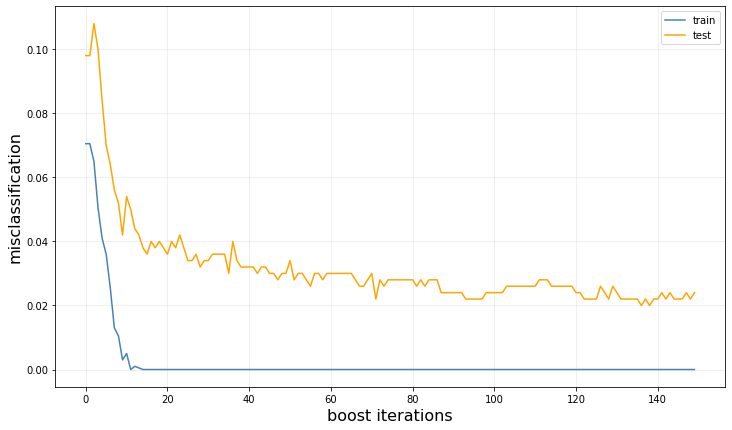

In [15]:
# plot misclassification error for train and test sets 
# your code here
train_scores = 1 - clf.staged_score(data.x_train, data.y_train)
test_scores = 1 - clf.staged_score(data.x_test, data.y_test)
# print(train_scores)
# print(test_scores)
iterations = range(0,len(test_scores))
# you can use this code to create your plot    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(iterations,train_scores,color="steelblue", label= 'train')
ax.plot(iterations,test_scores, color='orange', label='test')
ax.set_xlabel("boost iterations", fontsize=16)
ax.set_ylabel("misclassification", fontsize=16)
plt.legend()
plt.xticks(range(0,150,20))
ax.grid(alpha=.25)

### Problem 2 [25 pts] : Building an Random Forest Classifier to classify MNIST digits 3 and 8.

Remember that training the random forest algorithms involves the following steps: 

`for k=1 to K:`

$~~~~~~~$ `    a) build kth tree of depth d `

$~~~~~~~$ `    b) Return the kth tree trained on the subset of dataset with the random feature splits`

Predicting the classification result on new data involves returning the majority vote by all the trees in the random forest.


**2.a [10 points]:** Complete the `create_tree` function to build a new tree trained on a subset of data. Within this function a decision tree classifier is built and trained on the subset of data with the subset of features. 

In [16]:
class RandomForest():
    
    def __init__(self, x, y, sample_sz, n_trees=200, n_features='sqrt', max_depth=10, min_samples_leaf=5):
        """
        Create a new random forest classifier.
        
        Args:
            x : Input Feature vector
            y : Corresponding Labels
            sample_sz : Sample size
            n_trees : Number of trees to ensemble
            n_features : Method to select subset of features 
            max_depth : Maximum depth of the trees in the ensemble
            min_sample_leaf : Minimum number of samples per leaf 
        """
        np.random.seed(12)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
        print(self.n_features, "shape: ",x.shape[1])  
        self.features_set = []
        self.x, self.y, self.sample_sz, self.max_depth, self.min_samples_leaf  = x, y, sample_sz, max_depth, min_samples_leaf
        self.trees = [self.create_tree(i) for i in range(n_trees)]

    def create_tree(self,i):
        """
        create a single decision tree classifier
        """
        
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        idxs = np.asarray(idxs)

        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        f_idxs = np.asarray(f_idxs)
        
        
        if i==0:
            self.features_set = np.array(f_idxs, ndmin=2)
        else:
            self.features_set = np.append(self.features_set, np.array(f_idxs,ndmin=2),axis=0)
        
        # TODO: build a decision tree classifier and train it with x and y that is a subset of data (use idxs and f_idxs)
        
        # your code here
        
        clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
        x, y = self.x[idxs][:,f_idxs], self.y[idxs]
        return clf.fit(x,y)
        
       
    def predict(self, x):
        
        # TODO: create a vector of predictions and return
        # You will have to return the predictions of the final ensembles based on the individual trees' predicitons
        yhat = np.zeros(x.shape[0])
        tree_predictions = np.zeros((x.shape[0],1))
        for i in range(len(self.trees)):
            c_features = self.features_set[i] #set of features used in self.trees[i]
            xi = x[:,c_features] #slices all the rows of the features to be used in prediction
            s_pred = self.trees[i].predict(xi) #single tree prediction
            s_pred = s_pred.reshape(len(s_pred),1) #reshaped the array to be (500,1)
            tree_predictions = np.concatenate((tree_predictions,s_pred), axis=1) #concatenates tree_predictions to be shape (500, i+1)
        for i in range(len(tree_predictions)):
            majority = np.sign(np.sum(tree_predictions[i]))
            if majority == 0: #if no majority, set to 1
                majority = -1
            yhat[i] = majority
        return yhat
    
    def score(self, X, y):
        
#         # TODO: Compute the score using the predict function and true labels y
#         # your code here
        y_pred = self.predict(X)
        y_true = y

        score = np.sum(y_pred == y_true) / len(y_pred)

        return score
    

In [17]:
# tests create_tree function

In [18]:
rf = RandomForest(data.x_train, data.y_train, sample_sz=100)

21 shape:  441


**2.b [15 pts]:** In this part you will have to complete three steps: 

1. Complete the `predict` function in RandomForest class so as to make predictions using just the features. 
2. Finally complete the RandomForest class by completing the `score`function to compute the random forest model's accuracy on any dataset. 
3. Build a random forest classifier and train it on the MNIST data to classify 3s and 8s in the cell below. Then see how the classifier performs on the test data by computing the misclassification error. (Remember: error = 1-score)
<br>
Answer the Peer Review questions about this section. 

In [21]:
# TODO: build a random forest classifier and make predictions

# your code here
rf2 = RandomForest(data.x_train, data.y_train, sample_sz=100)
pred_score = 1 - rf2.score(data.x_test, data.y_test)

print('Misclassification error on test data : %0.3f'%pred_score)

21 shape:  441
Misclassification error on test data : 0.086
